## Hipótesis

**Los videojuegos de Nintendo son los más comentados en Twitter * (En idioma español / en los últimos 7 días)**

## Importaciones Iniciales

**Importación de bibliotecas y módulos**

In [2]:
# import tweepy as tw
# import os
# from dotenv import load_dotenv
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from src.functions import *


**Importación de Tokens y Keys**

In [2]:
# load_dotenv()
# Access_Token = os.getenv("TWITTER_TOKEN")
# Access_Secret = os.getenv("TWITTER_SECRET_TOKEN")
# Consumer_Key = os.getenv("TWITTER_API")
# Consumer_secret = os.getenv("TWITTER_SECRET_API")


# print(f"We have twitter tokens: {Access_Token[0:3]}, {Access_Secret[0:3]}", {Consumer_Key[0:3]}, {Consumer_secret[0:3]})

**Comprobación inicial de Tokens**

In [3]:
# auth = tw.OAuthHandler(Consumer_Key,Consumer_secret)
# auth.set_access_token(Access_Token, Access_Secret)
# api = tw.API(auth)

# public_tweets = api.home_timeline(count=2)
# for tweet in public_tweets:
#     print(tweet.text)

## Importación de Dataset

In [3]:
df = pd.read_csv("Inputs/Data - Videogames Sales.csv", encoding = "ISO-8859-1")

df.head(5)



,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


**Comprobamos y eliminamos las filas con valores nulos**

In [5]:
df2 = df.dropna().fillna(0)

df2.isnull().sum()

Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64

**Renombramos columnas con su correspondiente traducción**

In [6]:
df2.rename(columns={'Rank':'Ranking','Name':'Nombre', 'Platform':'Empresa', 'Year':'Fecha','Genre':'Genero', 'Publisher':'Editor', 'NA_Sales':'NA_Ventas', 'EU_Sales':'EU_Ventas', 'JP_Sales':'JP_Ventas', 'Other_Sales':'Otras_Ventas','Global_Sales':'Ventas_Globales'}, inplace=True)

df2 = df2[['Ranking', 'Nombre', 'Empresa', 'Fecha', 'Genero','Ventas_Globales']]

df2.head(5)


,Ranking,Nombre,Empresa,Fecha,Genero,Ventas_Globales
0,1,Wii Sports,Wii,2006.0,Sports,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,31.37


**Cambiamos de tipo aquellas columnas que son problemáticas**

In [7]:
df2["Fecha"] = df2.Fecha.astype(int)

df2["Fecha"].head(5)


0    2006
1    1985
2    2008
3    2009
4    1996
Name: Fecha, dtype: int64

**Ordenación de Dataframe en función de columna "Fecha" en orden ascendente a partir del año 2008**

In [8]:
df3 = df2.loc[df2['Fecha']>2007].sort_values(['Fecha','Ranking'], ascending=True).reset_index(drop=True)

df3.tail(5)

,Ranking,Nombre,Empresa,Fecha,Genero,Ventas_Globales
7988,16592,Chou Ezaru wa Akai Hana: Koi wa Tsuki ni Shiru...,PSV,2016,Action,0.01
7989,14393,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017,Role-Playing,0.03
7990,16244,Phantasy Star Online 2 Episode 4: Deluxe Package,PSV,2017,Role-Playing,0.01
7991,16441,Brothers Conflict: Precious Baby,PSV,2017,Action,0.01
7992,5959,Imagine: Makeup Artist,DS,2020,Simulation,0.29


**Agrupación de las consolas en función de su fabricante**

In [9]:
Listado_Empresas = df3.groupby('Empresa').count().reset_index()

Listado_Empresas['Empresa'].tolist()

['3DS',
 'DC',
 'DS',
 'PC',
 'PS2',
 'PS3',
 'PS4',
 'PSP',
 'PSV',
 'Wii',
 'WiiU',
 'X360',
 'XB',
 'XOne']

In [10]:
df3.Empresa = df3["Empresa"].apply(changeToBusiness)

Listado_Empresas = df3.groupby('Empresa').count().reset_index()

Listado_Empresas['Empresa'].tolist()

['Microsoft', 'Nintendo', 'Ordenador', 'Sega', 'Sony']

**Codificamos correctamente los nombres a un formato normalizado**

In [11]:
test_decode = df3['Nombre'].iloc[4]

test_decode

'PokÃ©mon Platinum Version'

In [12]:
test_decode.encode('latin-1')

b'Pok\xc3\xa9mon Platinum Version'

**Traducimos los géneros al idioma español**

In [13]:
# df3.Genero = df3["Genero"].apply(translation_deprecated)

# df3["Genero"].head(5)



In [14]:
df3.Genero = df3["Genero"].apply(local_translation)

df3["Genero"].head(5)

0    Carreras
1       Lucha
2      Accion
3      Accion
4         Rol
Name: Genero, dtype: object

## Tratamiento Inicial con API de Twitter

**Se reduce la envergadura del dataframe para su correcto uso junto a la API de Twitter (Sólo permite 180 request cada 15 minutos en versión gratuita)**

In [15]:
df3.shape

(7993, 6)

In [16]:
df4 = df3.sort_values(by=['Empresa','Fecha','Ventas_Globales'],ascending=True).reset_index(drop=True)

df4.head(5)

,Ranking,Nombre,Empresa,Fecha,Genero,Ventas_Globales
0,16056,Banjo-Kazooie,Microsoft,2008,Plataformas,0.01
1,14240,Summer Athletics: The Ultimate Challenge,Microsoft,2008,Deportes,0.03
2,14258,Crash Time: Autobahn Pusuit,Microsoft,2008,Carreras,0.03
3,14399,Otomedius Gorgeous,Microsoft,2008,Disparos,0.03
4,14772,Clannad,Microsoft,2008,Aventura,0.03


In [17]:

df5 = estructure_df(df4).reset_index(drop=True)

df5.shape

(113, 6)

**Preparamos el número de twitts por juego**

In [18]:
df5["Contador"] = df5["Nombre"].apply(twitt_counts)

df5



Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Python-dotenv could not parse statement starting at line 5
Rate limit reached. Sleeping for: 611
Rate limit reached

,Ranking,Nombre,Empresa,Fecha,Genero,Ventas_Globales,Contador
0,119,Gears of War 2,Microsoft,2008,Disparos,6.76,28
1,99,Call of Duty: World at War,Microsoft,2008,Disparos,7.37,3
2,52,Grand Theft Auto IV,Microsoft,2008,Accion,11.02,7
3,161,Forza Motorsport 3,Microsoft,2009,Carreras,5.51,1
4,134,Halo 3: ODST,Microsoft,2009,Disparos,6.36,16
5,37,Call of Duty: Modern Warfare 2,Microsoft,2009,Disparos,13.51,21
6,63,Halo: Reach,Microsoft,2010,Disparos,9.88,150
7,32,Call of Duty: Black Ops,Microsoft,2010,Disparos,14.64,411
8,16,Kinect Adventures!,Microsoft,2010,Etc,21.82,0
9,100,Battlefield 3,Microsoft,2011,Disparos,7.34,288


**Cacheamos los resultados para evitar usos de API innecesarios**

In [25]:
df5.to_csv('Twitts_tratados.csv')

df5.head(5)


,Ranking,Nombre,Empresa,Fecha,Genero,Ventas_Globales,Contador
0,119,Gears of War 2,Microsoft,2008,Disparos,6.76,28
1,99,Call of Duty: World at War,Microsoft,2008,Disparos,7.37,3
2,52,Grand Theft Auto IV,Microsoft,2008,Accion,11.02,7
3,161,Forza Motorsport 3,Microsoft,2009,Carreras,5.51,1
4,134,Halo 3: ODST,Microsoft,2009,Disparos,6.36,16


## Análisis de los resultados

**Juegos más comentados en los últimos 7 días**

In [63]:
df6 = df5

df7 = df6.groupby(['Nombre']).sum().sort_values('Contador', ascending=False).reset_index()

df7[['Nombre','Contador']].set_index('Nombre').head(10)

,Contador
Nombre,
Minecraft,30879
Overwatch,8899
Grand Theft Auto V,3136
FIFA 15,2537
FIFA 14,1096
Battlefield 3,866
Call of Duty: Black Ops,826
FIFA 17,668
Red Dead Redemption,618


**Géneros más comentados en los últimos 7 días**

In [82]:
df8 = df6.groupby(['Genero']).sum().sort_values('Contador', ascending=False).reset_index()

df8[['Genero','Contador']].set_index('Genero').head(10)

,Contador
Genero,
Etc,30933
Disparos,11952
Deportes,4785
Accion,3945
Rol,979
Simulacion,681
Carreras,501
Plataformas,198
Estrategia,97


**Relación de ventas con las interacciones en Twitter --> No hay correlación**

In [86]:
df9 = df6.groupby(['Ventas_Globales']).max().sort_values('Contador', ascending=False).reset_index()

df9 = df9[['Ventas_Globales','Contador']]

df9.corr(method="pearson")


,Ventas_Globales,Contador
Ventas_Globales,1.000000,-0.001024
Contador,-0.001024,1.000000


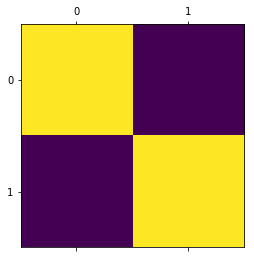

In [84]:

plt.matshow(df9.corr(method="pearson"))

Text(0.5,0,'Ventas_Globales')

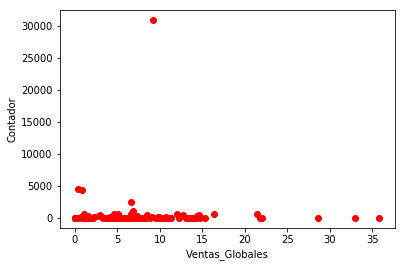

In [85]:
plt.plot(df9["Ventas_Globales"], df9["Contador"], "ro")
plt.ylabel("Contador")
plt.xlabel("Ventas_Globales")

## Respuesta a la hipótesis Principal

**¿Los videojuegos de Nintendo son los más comentados en Twitter? --> No, son los videojuegos de Microsoft**

In [91]:
df10 = df6.groupby(['Empresa']).sum().sort_values('Contador', ascending=False).reset_index()

df10[['Empresa','Contador']].set_index("Empresa")

,Contador
Empresa,
Microsoft,38294
Sony,7287
Ordenador,6815
Nintendo,1700
Sega,0


**Eliminamos factor 'Minecraft' del cálculo**

In [109]:
df11 = df6

df12 = df11[df11.Nombre != 'Minecraft']

df13 = df12.groupby(['Empresa']).sum().sort_values('Contador', ascending=False).reset_index()

df13[['Empresa','Contador']].set_index("Empresa")



,Contador
Empresa,
Microsoft,7415
Sony,7287
Ordenador,6815
Nintendo,1700
Sega,0


## La plataforma de videojuegos con mayores interacciones en Twitter es Microsoft